<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/8c_GRU_TextGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de texto usando una GRU

In [1]:
# establecer parametros para almacenar y cargar el conjunto de datos del repositorio de Github
import os

URL = 'https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/text_emotion.csv'
data_folder = 'data'
filepath = os.path.join(data_folder, 'text_emotion.csv')
print (f"filepath:\t{filepath}")

filepath:	data/text_emotion.csv


## Cargar el conjunto de datos

In [2]:
# crear carpeta para almacenar el conjunto de datos
! mkdir {data_folder}
# descargar conjunto de datos y alamcenar
! wget -nc {URL} -O {filepath}

--2022-03-08 14:27:39--  https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/text_emotion.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4394791 (4.2M) [text/plain]
Saving to: ‘data/text_emotion.csv’

data/text_emotion.c 100%[===================>]   4.19M  --.-KB/s    in 0.06s   

2022-03-08 14:27:39 (71.4 MB/s) - ‘data/text_emotion.csv’ saved [4394791/4394791]



In [3]:
# comprobrar
! ls -lh data/*

-rw-r--r-- 1 root root 4.2M Mar  8 14:27 data/text_emotion.csv


# Analizar conjunto de datos

In [4]:
import pandas as pd

df = pd.read_csv('data/text_emotion.csv')

# eliminar columnas 'tweet_id' y 'author'
df.drop('tweet_id',axis=1,inplace=True)
df.drop('author',axis=1,inplace=True)
print (df.head(10))
print (f"Longitud de tweets: {len(df):,}")

    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...
5       worry  Re-pinging @ghostridah14: why didn't you go to...
6     sadness  I should be sleep, but im not! thinking about ...
7       worry               Hmmm. http://www.djhero.com/ is down
8     sadness            @charviray Charlene my love. I miss you
9     sadness         @kelcouch I'm sorry  at least it's Friday?
Longitud de tweets: 40,000


1	8638	neutral
2	8459	worry
3	5209	happiness
4	5165	sadness
5	3842	love
6	2187	surprise
7	1776	fun
8	1526	relief
9	1323	hate
10	827	empty
11	759	enthusiasm
12	179	boredom
13	110	anger

40,000 tweets


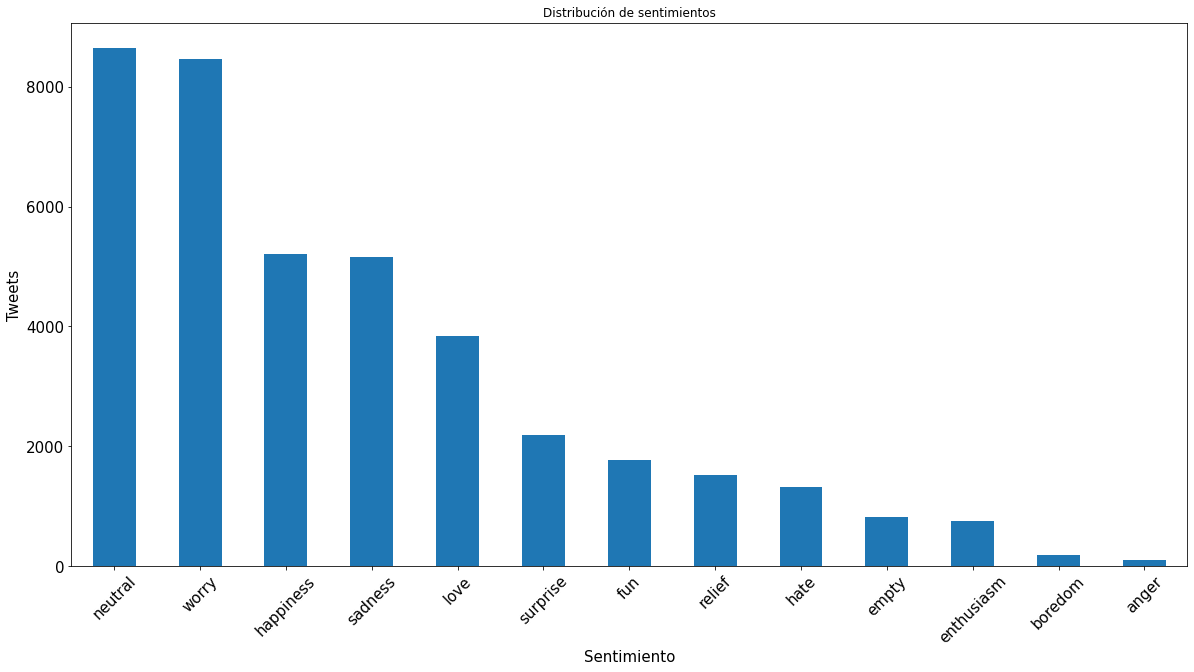

In [5]:
import matplotlib.pyplot as plt

sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

# Graficar la distribución
plt.figure(figsize=(20, 10))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("Tweets", fontsize="15")
plt.xticks(rotation=45, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

# Preprocesamiento de los datos
Realizar el preprocesamiento necesario, que incluye la limpieza y otros elementos como la toeknización y lematización

## Limpieza de los tweets

In [6]:
# preprocesamiento
import numpy as np
def limpiezaDeTweets(tweet):
  import re
  tweet = re.sub(r'RT @\w+: '," ", tweet) # eliminar retweets
  tweet = re.sub(r'https?://[A-Za-z0-9./]+', ' ', tweet) # eliminar urls
  tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet) # eliminar usuarios
  tweet = tweet.lower() # convertir a minúsculas
  tweet = re.sub(r'[^a-z0-9\'\.,:; ]+', ' ', tweet) # eliminar todos los caracteres que no esten en los definidos
  tweet = ' '.join(tweet.split()) # eliminar múltiples espacios, solo conservar un espacio

  return tweet


df['content'] = df['content'].astype('str')
df['content'] = df['content'].apply(lambda x: limpiezaDeTweets(x))

df.drop_duplicates(keep=False, inplace=True)

df = df.replace(r'^\s*$', np.NaN, regex=True)

df = df.dropna()

print (df.head(10))
print (f"\nTotal:\t{len(df):,}")


    sentiment                                            content
0       empty  i know i was listenin to bad habit earlier and...
1     sadness  layin n bed with a headache ughhhh...waitin on...
2     sadness                funeral ceremony...gloomy friday...
3  enthusiasm                wants to hang out with friends soon
4     neutral  we want to trade with someone who has houston ...
5       worry  re pinging : why didn't you go to prom bc my b...
6     sadness  i should be sleep, but im not thinking about a...
7       worry                                      hmmm. is down
8     sadness                       charlene my love. i miss you
9     sadness                     i'm sorry at least it's friday

Total:	39,314


In [7]:
# mostrar los tweets limpios por clase
sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

1	8380	neutral
2	8374	worry
3	5126	sadness
4	5099	happiness
5	3695	love
6	2181	surprise
7	1774	fun
8	1514	relief
9	1320	hate
10	805	empty
11	757	enthusiasm
12	179	boredom
13	110	anger

39,314 tweets


## Obtener solo la clase `happiness` como datos de entrada del modelo

In [8]:
happiness = df[df['sentiment'] == 'happiness']
tweets = happiness['content'].to_list()

print (f"\nLongitud de los tweets tweets: {len(tweets):,}")


Longitud de los tweets tweets: 5,099


# Generación de un solo tweet
Primero construiremos una red neuronal que pueda generar un tweet muy bien. Podemos elegir cualquier tweet (o cualquier otro texto) que queramos. Elijamos construir un RNN que genere texto a partir del `tweet[2000]`.

In [9]:
tweet = tweets[2000]
print (tweet)

yes... today is star wars day may the 4th be with you


### 1 Codificación
Codificar el tweet usando una codificación one-hot. Crearemos asignaciones de diccionario desde el carácter hasta el índice de ese carácter (un identificador entero único) y desde el índice hasta el carácter. Usaremos el mismo esquema de nombres que usa torchtext (stoi e itos).

El vocabulario es limitado ya que contiene solo los caracteres del `tweet[2000]`, más dos tokens especiales:

*   `<EOS>` representa el "fin de la cadena" (EOS: End Of Sentence), que agregaremos al final de nuestro tweet. Dado que los tweets son de longitud variable, esta es una forma en que GRU indica que se ha generado la secuencia completa.
*   `<BOS>` representa "comienzo de cadena" (BOS: Beginning Of Sentence), que agregaremos al comienzo de nuestro tweet. Este es el primer token que introduciremos en la GRU.



In [10]:
vocab = list(set(tweet)) + ["<BOS>", "<EOS>"]
vocab_stoi = {s: i for i, s in enumerate(vocab)}
vocab_itos = {i: s for i, s in enumerate(vocab)}
vocab_size = len(vocab)

print (f"longitud tweet:\t{len(tweet)}")
print (f"\nvocabulario:\t{vocab}")
print (f"\nvocab_stoi: \t{vocab_stoi}") # vocabulario stoi: string to index
print (f"\nvocab_itos: \t{vocab_itos}") # vocabulario itos: index to string
print (f"\nvocab_size: \t{vocab_size}") # longitud del vocabulario


longitud tweet:	53

vocabulario:	['a', '4', '.', 'e', 'i', 'd', 'r', 's', 'm', 'y', 'b', ' ', 't', 'o', 'u', 'w', 'h', '<BOS>', '<EOS>']

vocab_stoi: 	{'a': 0, '4': 1, '.': 2, 'e': 3, 'i': 4, 'd': 5, 'r': 6, 's': 7, 'm': 8, 'y': 9, 'b': 10, ' ': 11, 't': 12, 'o': 13, 'u': 14, 'w': 15, 'h': 16, '<BOS>': 17, '<EOS>': 18}

vocab_itos: 	{0: 'a', 1: '4', 2: '.', 3: 'e', 4: 'i', 5: 'd', 6: 'r', 7: 's', 8: 'm', 9: 'y', 10: 'b', 11: ' ', 12: 't', 13: 'o', 14: 'u', 15: 'w', 16: 'h', 17: '<BOS>', 18: '<EOS>'}

vocab_size: 	19


### 2 Modelo
Diseño del modelo de la red GRU

In [11]:
import torch
import torch.nn as nn

class TextGenerator(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(TextGenerator, self).__init__()

        # matriz de identidad para generar vectores one-hot
        self.ident = torch.eye(vocab_size)

        # recurrent neural network (Gated Recurrent Unit)
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

        # una capa totalmente conectada (FC) que genera una distribución sobre el siguiente token, dada la salida RNN
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input, hidden=None):
        # generar vectores one-hot de entrada
        input = self.ident[input]

        # obtener la siguiente salida y el estado oculto
        output, hidden = self.rnn(input, hidden)

        # predecir la distribución sobre los siguientes tokens
        output = self.fc(output)

        return output, hidden

In [12]:
# instanciar el modelo
model = TextGenerator(vocab_size, 64)
print (model)

TextGenerator(
  (rnn): GRU(19, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=19, bias=True)
)


### 3 Entrenamiento
Un modelo RNN genera texto un carácter a la vez en función del valor de estado oculto.

En cada paso de tiempo, comprueba si el modelo generó el carácter correcto.

Es decir, en cada paso de tiempo, está tratando de seleccionar el siguiente carácter correcto entre todos los caracteres del vocabulario.

Recordar que este problema es un problema de clasificación de clases múltiples, por lo que se usa la pérdida de entropía cruzada para entrenar la red.

In [13]:
# función de pérdida
loss_function = nn.CrossEntropyLoss()

Para comprender lo que sucede durante el entrenamiento de la RNN, iniciamos con un entrenamiento ineficiente, pero muestra lo que sucede paso a paso.

Calcular la pérdida del primer token generado, luego la del segundo token y así sucesivamente.

![Forward](https://drive.google.com/uc?id=1UJ9GajU6-iS7erkx5ppWgnZQWmIWc1V9)

Iniciamos generando el primer token (`tweet[0] = <BOS>`).



In [14]:
# para generar el primer token, se alimenta la red RNN (con un estado oculto vacío al inicio)
# con el token "<BOS>", así se obtiene la primer salida

bos_input = torch.Tensor([vocab_stoi["<BOS>"]]).long()
print (f"bos_input:\t{bos_input}\nshape:\t{bos_input.shape}")

bos_input = bos_input.unsqueeze(0) # agregar una dimensión
print (f"\nbos_input:\t{bos_input}\nshape:\t{bos_input.shape}")

# estado oculto vacío al inicio
output, hidden = model(bos_input, hidden=None)

# distribución obtenida sobre el primer token
print (f"output:\t{output}\n\noutput shape:\t{output.shape}")

bos_input:	tensor([17])
shape:	torch.Size([1])

bos_input:	tensor([[17]])
shape:	torch.Size([1, 1])
output:	tensor([[[-0.0391, -0.0530,  0.1076,  0.0435, -0.1071,  0.0537, -0.0199,
          -0.0592,  0.1420, -0.0148, -0.1026, -0.0987,  0.0592, -0.0386,
           0.0844, -0.1035,  0.1114,  0.1389,  0.0707]]],
       grad_fn=<AddBackward0>)

output shape:	torch.Size([1, 1, 19])


Ahora, calcular la pérdida usando `loss_function`. Dado que el modelo no está entrenado, se espera que la pérdida sea alta. (Por ahora, no haremos nada con esta pérdida y omitiremos el pase hacia atrás).

In [18]:
# definimos el target
print (f"vocab_stoi[tweet[0]]:\t{vocab_stoi[tweet[0]]}\t{tweet[0]}")

# convertir el id de a tensor con dos dimensiones
target = torch.Tensor([vocab_stoi[tweet[0]]]).long().unsqueeze(0)
print (f"\ntarget:\t{target.shape}")

# reshaping la salida a un tensor 2D
output = output.reshape(-1, vocab_size)
print (f"\noutput:\t{output.shape}")

# aplicar la función de pérdida, redimensionar el target a un tensor 1D 
loss = loss_function(output, target.reshape(-1))

print (f"\nloss:\t{loss}")

vocab_stoi[tweet[0]]:	9	y

target:	torch.Size([1, 1])

output:	torch.Size([1, 19])

loss:	2.9719738960266113


Lo siguiente es actualizar el estado oculto y generar una predicción para el siguiente token.

Para hacerlo, se debe proporcionar el token actual a la RNN.

Durante el tiempo de prueba, se necesita tomar muestras de la probabilidad predicha sobre los tokens que acaba de generar la red neuronal.

Sin embargo se puede hacer algo mejor: usar el token objetivo real (**the ground-truth or actual target token**). 

Esta técnica se llama **teacher-forcing** y generalmente acelera el entrenamiento.

La razón es que en este momento, dado que el modelo no funciona bien, la distribución de probabilidad predicha está bastante lejos del target objetivo real.

Por lo tanto, es bastante difícil para la red neuronal volver a entrenar con datos de entrada incorrectos.

In [19]:
# Usar el teacher-forcing: pasamos en el token objetivo real (target), en lugar de usar la distribución predicha de la RNN

output, hidden = model(target, hidden)

print (f"output:\t{output}\n\n{output.shape}") # distribución obtenida del segundo token

output:	tensor([[[-0.0456, -0.0288,  0.1007,  0.0183, -0.0934,  0.0529, -0.0484,
          -0.0452,  0.1430, -0.0322, -0.1153, -0.0972,  0.0470, -0.0309,
           0.0630, -0.0992,  0.1450,  0.0962,  0.0367]]],
       grad_fn=<AddBackward0>)

torch.Size([1, 1, 19])


De forma similar al primer paso, calcular la pérdida, cuantificando la diferencia entre la distribución prevista y el siguiente token objetivo real.

Esta pérdida se puede utilizar para ajustar los pesos de la red neuronal (que aún no se está haciendo).

In [20]:
# definimos el segundo target
print (f"vocab_stoi[tweet[1]]:\t{vocab_stoi[tweet[1]]}\t{tweet[1]}")

# convertir el target siguiente "tweet[1]" a tensores 2D
target = torch.Tensor([vocab_stoi[tweet[1]]]).long().unsqueeze(0)

# reshaping la salida a un tensor 2D
output = output.reshape(-1, vocab_size)
print (f"\noutput:\t{output.shape}")

# aplicar la función de pérdida, redimensionar el target a un tensor 1D 
loss = loss_function(output, target.reshape(-1))

print (f"\nloss:\t{loss}")

vocab_stoi[tweet[1]]:	3	e

output:	torch.Size([1, 19])

loss:	2.9328465461730957


Podemos continuar este proceso de: 

*   alimentar el token objetivo real a la RNN,
*   obtener la distribución de predicción sobre el siguiente token,
*   y calcular la pérdida

esto se hace tantos pasos como tokens haya en el tweet **ground-truth**.

In [22]:
# definir un ciclo for que realice los cálculos del resto de tokens del tweet
for i in range(2, len(tweet)): # inicializar en 2, ya se cálculo el 0 y 1
    # target anterior
    output, hidden = model(target, hidden)
     # target actual
    target = torch.Tensor([vocab_stoi[tweet[i]]]).long().unsqueeze(0)
    # redimensionar output a un tensor 2D, redimensionar el target a un tensor 1D y calcular la pérdida
    loss = loss_function(output.reshape(-1, vocab_size), target.reshape(-1))
    
    print(f"i: {i} char: {tweet[i]}\noutput: {output}\nloss: {loss}")

i: 2 char: s
output: tensor([[[-0.1227, -0.0954,  0.1078,  0.0081, -0.0936,  0.0408, -0.0514,
          -0.0643,  0.2361, -0.0886, -0.0466, -0.1203,  0.0868, -0.0419,
           0.0696, -0.1237,  0.0742,  0.0729,  0.0633]]],
       grad_fn=<AddBackward0>)
loss: 3.008781671524048
i: 3 char: .
output: tensor([[[-0.0963, -0.0436,  0.1121, -0.0275, -0.0400,  0.0635, -0.0068,
          -0.0712,  0.1838, -0.0654, -0.0787, -0.0723,  0.0987,  0.0198,
           0.0636, -0.0795,  0.0879,  0.0546,  0.0718]]],
       grad_fn=<AddBackward0>)
loss: 2.844703197479248
i: 4 char: .
output: tensor([[[-0.0954, -0.0579,  0.1086,  0.0029, -0.0601,  0.0946, -0.0369,
          -0.0588,  0.1831, -0.0466, -0.1060, -0.0839,  0.1165,  0.0034,
           0.0533, -0.0693,  0.0661,  0.0808,  0.0457]]],
       grad_fn=<AddBackward0>)
loss: 2.8466503620147705
i: 5 char: .
output: tensor([[[-0.0919, -0.0734,  0.1113,  0.0175, -0.0703,  0.1114, -0.0584,
          -0.0486,  0.1840, -0.0444, -0.1145, -0.0952,  0.1272, -

**Finalmente, con el token final, deberíamos esperar generar el token `<EOS>`, para que la RNN aprenda cuándo dejar de generar caracteres.**

In [23]:
# ingresar el target anterior y el estado olculto anterior al modelo
output, hidden = model(target, hidden)

# obtener el tensor en 2D del caracter <EOS>
eos = vocab_stoi["<EOS>"]
target = torch.Tensor([eos]).long().unsqueeze(0)

# redimensionar output a un tensor 2D, redimensionar el target a un tensor 1D y calcular la pérdida
loss = loss_function(output.reshape(-1, vocab_size), target.reshape(-1))

print(f"char:{vocab_itos[eos]} output: {output} loss: {loss}")

char:<EOS> output: tensor([[[-0.0690, -0.0199,  0.1051,  0.0013, -0.0909,  0.1138, -0.0907,
          -0.0689,  0.2025, -0.0648, -0.0478, -0.0551,  0.1143, -0.0109,
           0.0811, -0.0759,  0.0703,  0.0535,  0.0033]]],
       grad_fn=<AddBackward0>) loss: 2.9526774883270264


> NOTA: En la práctica, realmente no necesitamos un bucle. Hay que recordar que en una RNN, el módulo `nn.RNN` puede tomar una secuencia completa como entrada.

Podemos hacer lo mismo aquí:



In [24]:
# definir el tweet de caracteres, poner al inicio y fin los tokens "especiales"
tweet_char = ["<BOS>"] + list(tweet) + ["<EOS>"]

# obtener los índices del tweet
tweet_indexes = [vocab_stoi[ch] for ch in tweet_char]

# convertir el tweet codificado a tensores en 2D
tweet_tensor = torch.Tensor(tweet_indexes).long().unsqueeze(0)

# visuaizar el shape del tensor
print(f"tweet_tensor.shape:\t{tweet_tensor.shape}\n") # [1, 55] --> 53 (tweet) + 2 (tokens especiales)

print (f"tweet_tensor:\t{tweet_tensor}\n")
print (f'17:\t{vocab_itos[17]}\t18:\t{vocab_itos[18]}\n\n')

print (f"tweet_tensor[:,:-1]:\t{tweet_tensor[:,:-1]}\n\n") # <EOS> nunca es un token de entrada
print (f"tweet_tensor[:,1:]:\t{tweet_tensor[:,1:]}\n\n") # <BOS> nunca es un token objetivo

# ingresar el tweet al modelo
output, hidden = model(tweet_tensor[:,:-1])

# vector de targets
target = tweet_tensor[:,1:]

# redimensionar output a un tensor 2D, redimensionar el target a un tensor 1D y calcular la pérdida
loss = loss_function(output.reshape(-1, vocab_size), target.reshape(-1))

print (f"pérdida:\t{loss}")

tweet_tensor.shape:	torch.Size([1, 55])

tweet_tensor:	tensor([[17,  9,  3,  7,  2,  2,  2, 11, 12, 13,  5,  0,  9, 11,  4,  7, 11,  7,
         12,  0,  6, 11, 15,  0,  6,  7, 11,  5,  0,  9, 11,  8,  0,  9, 11, 12,
         16,  3, 11,  1, 12, 16, 11, 10,  3, 11, 15,  4, 12, 16, 11,  9, 13, 14,
         18]])

17:	<BOS>	18:	<EOS>


tweet_tensor[:,:-1]:	tensor([[17,  9,  3,  7,  2,  2,  2, 11, 12, 13,  5,  0,  9, 11,  4,  7, 11,  7,
         12,  0,  6, 11, 15,  0,  6,  7, 11,  5,  0,  9, 11,  8,  0,  9, 11, 12,
         16,  3, 11,  1, 12, 16, 11, 10,  3, 11, 15,  4, 12, 16, 11,  9, 13, 14]])


tweet_tensor[:,1:]:	tensor([[ 9,  3,  7,  2,  2,  2, 11, 12, 13,  5,  0,  9, 11,  4,  7, 11,  7, 12,
          0,  6, 11, 15,  0,  6,  7, 11,  5,  0,  9, 11,  8,  0,  9, 11, 12, 16,
          3, 11,  1, 12, 16, 11, 10,  3, 11, 15,  4, 12, 16, 11,  9, 13, 14, 18]])


pérdida:	2.973177671432495


La entrada del modelo de red neuronal es la secuencia completa de tokens de entrada del tweet (todo, desde `<BOS>` hasta el último carácter del tweet).

La red neuronal genera una distribución de predicción del siguiente token en cada paso.

Se puede comparar cada uno de estos con el objetivo real (**the ground-truth or actual target token**).

In [25]:
# ciclo de entrenamiento (para aprender a generar el tweet único):

# definir optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# definir la función de pérdida
loss_function = nn.CrossEntropyLoss()

EPOCHS = 500

for i in range(EPOCHS):
    optimizer.zero_grad()

    output, _ = model(tweet_tensor[:,:-1])
    
    # redimensionar output a un tensor 2D, redimensionar el target a un tensor 1D y calcular la pérdida
    loss = loss_function(output.reshape(-1, vocab_size), target.reshape(-1))

    # backpropagation
    loss.backward()
    
    # actualizar los pesos
    optimizer.step()

    # imprimir el "epoch" y la pérdida
    if (i+1) % 100 == 0:
        print(f"[Iteración {i+1}] Loss {float(loss)}")

[Iteración 100] Loss 1.7664942741394043
[Iteración 200] Loss 0.23335959017276764
[Iteración 300] Loss 0.04398748278617859
[Iteración 400] Loss 0.018776724115014076
[Iteración 500] Loss 0.010813253000378609


La pérdida obtenida del entrenamiento está disminuyendo con el entrenamiento, que es lo que esperamos.

# Generación de un token
En este punto, se desea ver si el modelo realmente está aprendiendo algo.

Entonces, ¿Cómo se va a utilizar el modelo para generar texto?. 

Si podemos generar texto, podemos hacer una evaluación cualitativa de qué tan bien está funcionando la RNN.

La principal diferencia entre el entrenamiento y el test (tiempo de generación) es que no tenemos los tokens verdaderos para alimentarlos como entradas a la RNN. En su lugar, se necesita muestrear un token en función de la distribución de predicción de la red neuronal.

Pero, ¿cómo podemos probar un token de una distribución?

Por un lado, siempre se puede tomar el token con mayor probabilidad (argmax). Esta ha sido la técnica de referencia en otras tareas de clasificación. 

Sin embargo, esta idea fallará aquí. La razón es que, en la práctica, **queremos poder generar una variedad de secuencias diferentes a partir del mismo modelo**. Una RNN que solamente pueda generar un nuevo tweet `happiness` es bastante inútil.

En resumen, queremos algo de aleatoriedad. Se puede hacer usando los `logits` de salida del modelo para construir una distribución multinomial sobre los tokens y luego muestrear un token aleatorio de esa distribución multinomial.

> **logits**: *son interpretados como predicciones (o resultados) no normalizadas (o aún no normalizadas) de un modelo.*

Una distribución multinomial que se puede elegir es la distribución que se obtiene después de aplicar el la función `softmax` en las salidas. Sin embargo, haremos una cosa más: 

Se agrega un **parámetro de temperatura** para manipular las salidas de la función `softmax`.

Se puede establecer una temperatura más alta para que la probabilidad de cada token sea más uniforme (más aleatoria), o una temperatura más baja para asignar más probabilidad a los tokens con un `logit` más alto (salida). 

Una temperatura más alta significa que obtendremos una muestra más diversa, con potencialmente más errores.

Una temperatura más baja significa que podemos ver repeticiones de la misma secuencia de alta probabilidad.


In [32]:
def sample_sequence(model, max_len=100, temperature=0.8):
    generated_sequence = ""
   
    # entrada
    inp = torch.Tensor([vocab_stoi["<BOS>"]]).long()

    # capa de estados ocultos
    hidden = None

    # iterar para generar texto
    for p in range(max_len):
        # pasar parámetros al modelo. Agregar una dimension a inp --> tensor 2D
        output, hidden = model(inp.unsqueeze(0), hidden)

        # obtener una muestra de la red como una distribución multinomial
        # torch.div(input, other) --> divide cada elemento de la entrada "input" por el elemento correspondiente de "other".
        # torch.exp(input) --> devuelve un nuevo tensor con la exponencial de los elementos del tensor de entrada "input".
        # print (f"output.shape:\t{output.shape}") # torch.Size([1, 1, 19])
        # print (f"output.data.view(-1):\t{output.data.view(-1).shape}") # torch.Size([19])
        output_dist = output.data.view(-1).div(temperature).exp()

        # torch.multinomial(input, num_samples) --> devuelve un tensor donde cada fila contiene índices muestreados ("num_samples") de la distribución 
        # de probabilidad multinomial ubicada en la fila correspondiente del tensor "input".
        top_i = int(torch.multinomial(output_dist, 1)[0]) # obtener el mejor

        # agregar el carácter predicho a la cadena y utilizarlo como siguiente entrada
        predicted_char = vocab_itos[top_i]
        
        # si se llega al final de la secuencia (tweet) predicha, salir del ciclo
        if predicted_char == "<EOS>":
            break

        # agregar el caracter predicho a la cadena generada  
        generated_sequence += predicted_char

        # convertir la siguiente entrada a un tensor long
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

print (tweet,'\n')

print(sample_sequence(model, temperature=0.5))
print(sample_sequence(model, temperature=0.8))
print(sample_sequence(model, temperature=1.0))
print(sample_sequence(model, temperature=1.5))
print(sample_sequence(model, temperature=2.0))
print(sample_sequence(model, temperature=5.0))

yes... today is star wars day may the 4th be with you 

yes... today is star wars day may the 4th be with you
yes... today is star wars day may the 4th be with you
yes... today is star wars may may they4th be with you
yes... today ys.sttr wsrs.day may the 4th be 4ithyyou
yee...stodayeiahstar wsrr yay idr toh 4thybo  <BOS>eh. try ii thds thr ith be
ys<BOS>w.sm  de oiamatrdh4disiiuy uhrtma


Dado que solo se ha entrenado el modelo en una sola secuencia, aún no se observa el efecto del parámetro de `temperatura`. 

Por ahora, el resultado de las llamadas a la función `sample_sequence` indica que el entrenamiento parece razonable.

# Ejercicio
Completar el entrenamiento con el conjunto de datos completo.


*   Usar los tweets de la clase `happiness`, y
*   el conjunto de tweets (100) en español de la clase pasada.
*   O emplear el libro "The Time Machine, by H. G. Wells [1898]" del repositorio, o utilizar otro libro en español para generar texto con la GRU.  

